# Introduction

The following notebook is work-in-progress for the CORD-19-research-challenge on Kaggle.  
Our goal is to be able to search the dataset and find some answers to the tasks that are defined on Kaggle. We are usind mutiple embbeddings such as word2Vec or a simple td-idf on the papers.

## Dataset

(1) Metadata for papers from these sources are combined: CZI, PMC, BioRxiv/MedRxiv. (total records 29500)  
	- CZI 1236 records  
	- PMC 27337  
	- bioRxiv 566  
	- medRxiv 361  
    
(2) 17K of the paper records have PDFs and the hash of the PDFs are in 'sha'

(3) For PMC sourced papers, one paper's metadata can be associated with one or more PDFs/shas under that paper - a PDF/sha correponding to the main article, and possibly additional PDF/shas corresponding to supporting materials for the article.

(4)	13K of the PDFs were processed with fulltext ('has_full_text'=True)

(5) Various 'keys' are populated with the metadata:  
	- 'pmcid': populated for all PMC paper records (27337 non null)  
	- 'doi': populated for all BioRxiv/MedRxiv paper records and most of the other records (26357 non null)  
	- 'WHO #Covidence': populated for all CZI records and none of the other records (1236 non null)  
	- 'pubmed_id': populated for some of the records  
	- 'Microsoft Academic Paper ID': populated for some of the records  

# Setup

## Import packages

In [1]:
import pandas as pd
import numpy as np
import scipy as sc

%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mpld3
import mplcursors

import json
import os
import glob
import re
import warnings
import random
import spacy
from itertools import chain
from collections import  namedtuple

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize

from wordcloud import WordCloud

from gensim.models import Word2Vec, doc2vec
from gensim.utils import simple_preprocess

from rank_bm25 import BM25Okapi

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

#from sentence-transformers import SentenceTransformer
import transformers


Bad key "text.kerning_factor" on line 4 in
C:\Users\m_lev\Anaconda3\envs\ml4hc\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


## Download the stopwords and special characters

In [2]:
nltk.download('stopwords')
stopwords.words('english')
nltk.download('punkt')
warnings.filterwarnings(action='once')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\m_lev\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\m_lev\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data processing

### Collect json files

In [24]:
# get all paths
filepath_biorxiv = '.data/biorxiv_medrxiv/biorxiv_medrxiv/'
filepath_noncomm = '.data/noncomm_use_subset/noncomm_use_subset'
filepath_comm = './data/comm_use_subset/comm_use_subset'
filepath_custom = '.data/custom_license/custom_license'

In [4]:
# enumerate json files
all_json_files = glob.glob(f'data/**/*.json', recursive=True)
biorxiv_json_files = glob.glob(f'data/biorxiv_medrxiv/**/*.json', recursive=True)
noncomm_json_files =  glob.glob(f'data/noncomm_use_subset/**/*.json', recursive=True)
comm_json_files = glob.glob(f'data/comm_use_subset/**/*.json', recursive=True)
custom_json_files = glob.glob(f'data/custom_license/**/*.json', recursive=True)

### Create dictionary
Create a dictionary with the plain texts, indexing all papers with it's ID, store dictionary as json

In [60]:
metadata_df = pd.read_csv('data/metadata.csv')
# convert metadata_df to numpy array
metadata_np = np.array(metadata_df)

# extract the indecies of important properties
cord_uid_index = metadata_df.columns.get_loc("cord_uid")
sha_index = metadata_df.columns.get_loc("sha")
title_index = metadata_df.columns.get_loc("title")
abstract_index = metadata_df.columns.get_loc("abstract")
authors_index = metadata_df.columns.get_loc("authors")
journal_index = metadata_df.columns.get_loc("journal")
publish_time_index = metadata_df.columns.get_loc("publish_time")
has_pdf_parse_index = metadata_df.columns.get_loc("has_pdf_parse")
full_text_file_index = metadata_df.columns.get_loc("full_text_file")
url_index = metadata_df.columns.get_loc("url")

In [70]:
paper_dict = {}
for i in range(metadata_np.shape[0])[0:1000]:
    # extract body text from json file if possible
    has_pdf_parse = metadata_np[i][has_pdf_parse_index]
    if has_pdf_parse:
        full_text_file = metadata_np[i][full_text_file_index]
        sha = metadata_np[i][sha_index]

        json_file_glob = 'data/{0}/**/{1}.json'.format(full_text_file, sha)
        paper = glob.glob(json_file_glob, recursive=True)
        
        body_text = ''
        try:
            with open(os.path.join(paper[0])) as json_file:
                paper_json = json.load(json_file)
                body_text = concat_json_properties(paper_json['body_text'], 'text')
        except:
            pass
        
    # create dict
    paper_dict[metadata_np[i][cord_uid_index]] = {
        'sha': sha,
        'title': metadata_np[i][title_index],
        'authors': metadata_np[i][authors_index],
        'abstract': metadata_np[i][abstract_index],
        'body_text': body_text,
        'publish_date': metadata_np[i][publish_time_index],
        'journal': metadata_np[i][journal_index],
        'url': metadata_np[i][url_index],
    }

with open('paper_dict.json', 'w') as fw:
    json.dump(paper_dict, fw, indent=2)

Load the dictionary from the json file

In [5]:
paper_dict = {}
with open('paper_dict.json', 'r') as fp:
    paper_dict = json.load(fp)

## Helper functions

In [5]:
def preprocessing(text, additional_stopwords=[]):
    preprocessed_text = simple_preprocess(text)
    filtered_list = []
    for token in preprocessed_text:
      if token in stopwords.words('english') or token in additional_stopwords  or token.isnumeric():
          continue
      filtered_list.append(token)
    return filtered_list

In [6]:
def get_preprocessed_text_from_files(json_files, attribute):
  preprocessed_text = [] 
  for json_file in json_files:
    with open(os.path.join(json_file)) as json_file:
        json_object = json.load(json_file)
        
        attribute_object = json_object[attribute]
        text = concat_json_properties_as_string(attribute_object, 'text')
        
        preprocessed_text_ = preprocessing(str(text))
        preprocessed_text.append(preprocessed_text_)
        
  return preprocessed_text

In [7]:
def get_preprocessed_sentences_from_files(json_files, attribute):
  preprocessed_tokenized_sentences = []
  for json_file in json_files:
    with open(os.path.join(json_file)) as json_file:
        json_object = json.load(json_file)
    
        try:
            text = concat_json_properties_as_string(json_object[attribute], 'text')
            all_sentences = nltk.sent_tokenize(text)

            preprocessed_sentences = []
            for sentence in all_sentences:
                preprocessed_sentences.append(preprocessing(sentence))

            preprocessed_tokenized_sentences.extend(preprocessed_sentences)
        except:
            pass
        
  return preprocessed_tokenized_sentences

In [53]:
def get_preprocessed_sentences_from_files(json_files, attribute):
  preprocessed_tokenized_sentences = []
  for json_file in json_files:
    with open(os.path.join(json_file)) as json_file:
        json_object = json.load(json_file)
    
        attribute_object = json_object[attribute]
        text = concat_json_properties_as_string(attribute_object, 'text')
        
        if text != '':
            all_sentences = nltk.sent_tokenize(text)

            preprocessed_sentences = []
            for sentence in all_sentences:
                preprocessed_sentences.append(preprocessing(sentence))

            preprocessed_tokenized_sentences.extend(preprocessed_sentences)
        
  return preprocessed_tokenized_sentences

In [8]:
def get_section_text(body_text, section_name_pattern):
    for section in body_text:
        section_name = section['section']
        if section_name_pattern in section_name.lower():
            return section['text']
        else:
            return 'none'

In [9]:
def concat_json_properties(json_list_element, property_name):
    concatenated_content = []
    for item in json_list_element:
        concatenated_content.append(item[property_name])
    return concatenated_content

In [10]:
def concat_json_properties_as_string(json_list_element, property_name):
    concatenated_content = ''
    for item in json_list_element:
        concatenated_content = concatenated_content + item[property_name]
    return concatenated_content

In [11]:
def visualize_word_frequencies(feature):
    fig = plt.figure(figsize=(8,4))
    plot = fig.add_subplot()
    wordcloud = WordCloud()
    frequency_dist = nltk.FreqDist(feature)
    sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:50] 
    wordcloud.generate_from_frequencies(frequency_dist)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [12]:
def get_dict_element_by_key(element_key):
    text = []
    for key in paper_dict:
        string = paper_dict[key][element_key]
        if (string != 'nan' and string != ''):
            text.append(string)
    return text

# Dataset analysis

(1) Metadata for papers from these sources are combined: CZI, PMC, BioRxiv/MedRxiv. (total records 29500)  
	- CZI 1236 records  
	- PMC 27337  
	- bioRxiv 566  
	- medRxiv 361  
    
(2) 17K of the paper records have PDFs and the hash of the PDFs are in 'sha'

(3) For PMC sourced papers, one paper's metadata can be associated with one or more PDFs/shas under that paper - a PDF/sha correponding to the main article, and possibly additional PDF/shas corresponding to supporting materials for the article.

(4)	13K of the PDFs were processed with fulltext ('has_full_text'=True)

(5) Various 'keys' are populated with the metadata:  
	- 'pmcid': populated for all PMC paper records (27337 non null)  
	- 'doi': populated for all BioRxiv/MedRxiv paper records and most of the other records (26357 non null)  
	- 'WHO #Covidence': populated for all CZI records and none of the other records (1236 non null)  
	- 'pubmed_id': populated for some of the records  
	- 'Microsoft Academic Paper ID': populated for some of the records



## Publications of papers

The dataset contains research papers that have been published in various journals

In [71]:
journal_names = get_dict_element_by_key('journal')
        
values, counts = np.unique(journal_names, return_counts=True)
print(values)
print(counts)

['AIDS Res Ther' 'Acta Crystallogr D Biol Crystallogr' 'Acta Vet Scand'
 'Adv Bioinformatics' 'Ann Clin Microbiol Antimicrob' 'Ann Thorac Med'
 'Annals of Botany' 'Arch Virol' 'Arthritis Res Ther' 'Asia Pac Fam Med'
 'Aust New Zealand Health Policy' 'BMC Bioinformatics' 'BMC Biol'
 'BMC Biotechnol' 'BMC Cell Biol' 'BMC Dev Biol' 'BMC Evol Biol'
 'BMC Fam Pract' 'BMC Gastroenterol' 'BMC Genomics' 'BMC Health Serv Res'
 'BMC Immunol' 'BMC Infect Dis' 'BMC Med' 'BMC Med Ethics' 'BMC Med Genet'
 'BMC Med Genomics' 'BMC Med Inform Decis Mak' 'BMC Med Res Methodol'
 'BMC Microbiol' 'BMC Mol Biol' 'BMC Musculoskelet Disord' 'BMC Physiol'
 'BMC Plant Biol' 'BMC Pregnancy Childbirth' 'BMC Public Health'
 'BMC Pulm Med' 'BMC Res Notes' 'BMC Struct Biol' 'BMC Vet Res' 'BMJ'
 'Biochemistry' 'Biol Proced Online' 'Biology of Reproduction'
 'Biomolecular NMR Assignments' 'Biotechnol J' 'Br J Cancer' 'Brain'
 'Brain Pathol' 'Case Rep Med' 'Cases J' 'Cell Death & Differentiation'
 'Cell Microbiol' 'Cli

<IPython.core.display.Javascript object>


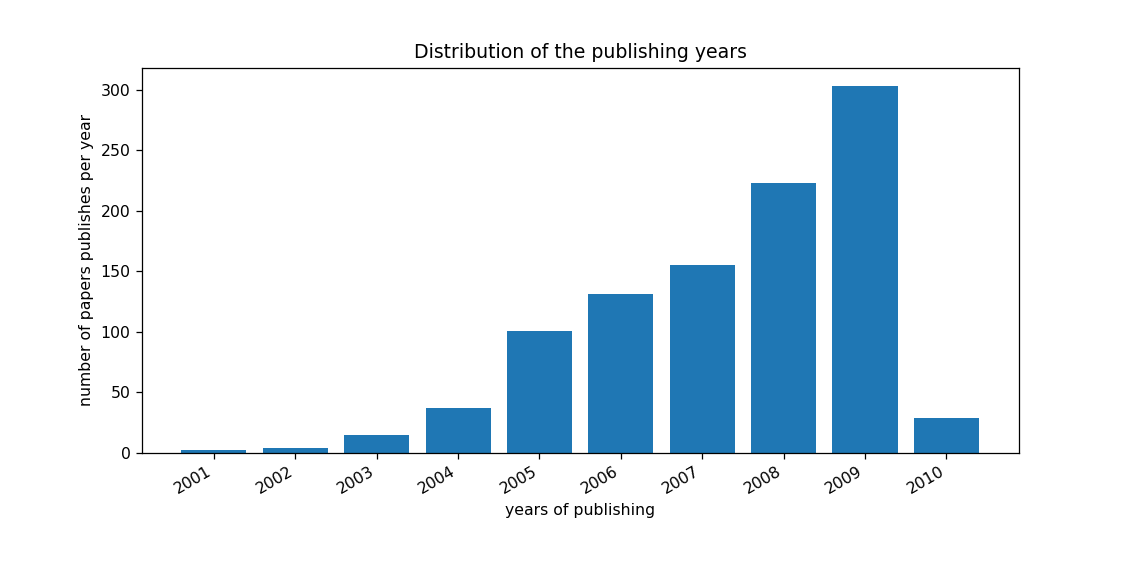

In [72]:
publish_years = []
for key in paper_dict:
    string_date = str(paper_dict[key]['publish_date'])
    if (string_date != 'nan' and string_date != ''):
        match = re.search('[0-9]{4}', string_date)
        
        if match:
            publish_year = match.group(0)
            publish_years.append(publish_year)
        else:
            print(string_date)
            
get_dict_element_by_key('journal')
# plot the distribution of the publishing years
x, y = np.unique(publish_years, return_counts=True)
fig = plt.figure(figsize=(10,5))
plot = fig.add_subplot()
plot.bar(x,y)
plt.gcf().autofmt_xdate()
plt.title("Distribution of the publishing years")
plt.xlabel("years of publishing")
plt.ylabel("number of papers publishes per year")

mplcursors.cursor(hover=True)

plt.show()

## Topics

The dataset is not limited to papers specifically about COVID-19 but also covers topis about multiple other viruses. 

In [73]:
titles = get_dict_element_by_key('title')

In [74]:
# Print random document titles
titles_to_print = random.choices(titles, k=20)
print('\n'.join(titles_to_print))

Increasing Incidence of Zygomycosis (Mucormycosis), France, 1997–2006
Evidence that Gag facilitates HIV-1 envelope association both in GPI-enriched plasma membrane and detergent resistant membranes and facilitates envelope incorporation onto virions in primary CD4(+ )T cells
Identification and Characterization of a New Orthoreovirus from Patients with Acute Respiratory Infections
Reading chest radiographs in the critically ill (Part II): Radiography of lung pathologies common in the ICU patient
MMDB: annotating protein sequences with Entrez's 3D-structure database
Bovine Respiratory Syncytial Virus (BRSV) Pneumonia in Beef Calf Herds Despite Vaccination
High level expression of soluble glycoproteins in the allantoic fluid of embryonated chicken eggs using a Sendai virus minigenome system
Detection of Novel SARS-like and Other Coronaviruses in Bats from Kenya
Short-hairpin RNAs delivered by lentiviral vector transduction trigger RIG-I-mediated IFN activation
Caveolin-1 and -2 in airway 

<IPython.core.display.Javascript object>


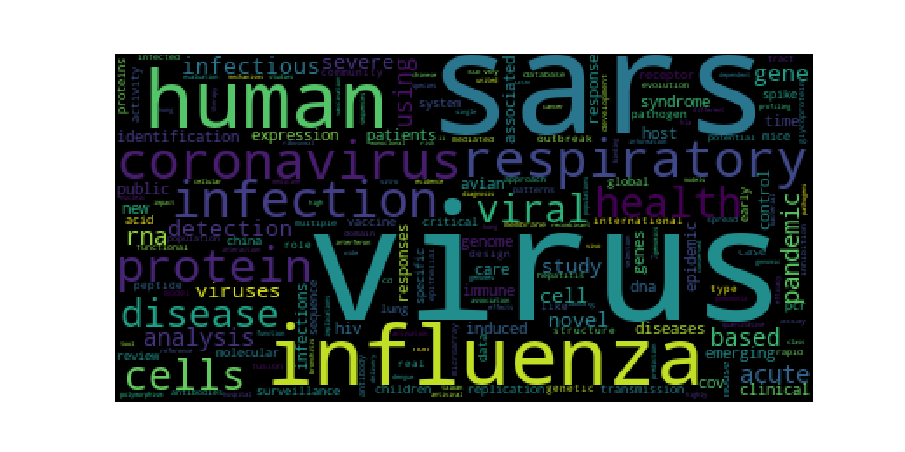

In [75]:
topics = []
for title in titles:
    topics.extend(preprocessing(title))

visualize_word_frequencies(topics)

In [20]:
titles = np.array(get_dict_element_by_key('title'))

tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(titles)

## Visualize the word frequencies

<IPython.core.display.Javascript object>


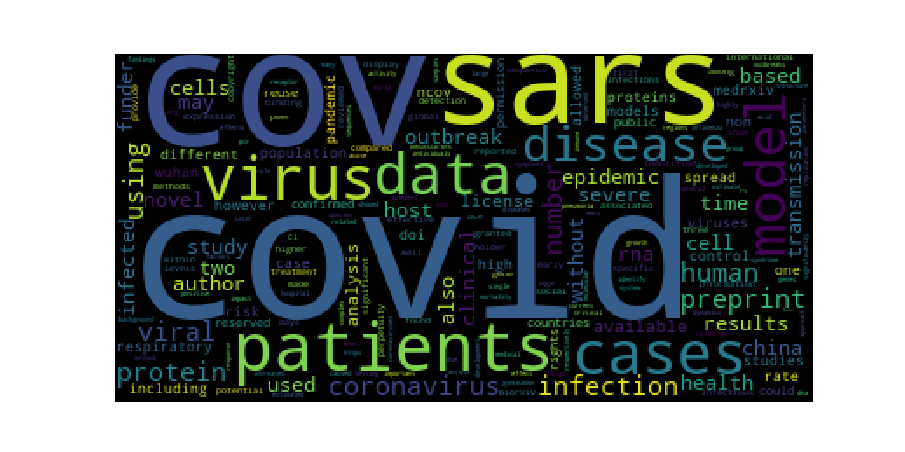

In [13]:
preprocessed_biorxiv_abstract_text = get_preprocessed_text_from_files(biorxiv_json_files, 'abstract')

visualize_word_frequencies(chain(*preprocessed_biorxiv_abstract_text))

In [ ]:
noncomm_biorxiv_abstract_text = get_preprocessed_text_from_files(noncomm_json_files, 'abstract')

visualize_word_frequencies(chain(*noncomm_biorxiv_abstract_text))

# Build word2vec models for the data sets

Explore som similarities of words in the data biorxiv data set

In [54]:
# collect all abstracts from the data biorxiv data set
biorxiv_abstracts = get_preprocessed_sentences_from_files(biorxiv_json_files, 'abstract')

# build vocabulary and train model for the biorxiv data set
biorxiv_model = Word2Vec(
    sentences=biorxiv_abstracts,
    window=10,
    min_count=2,
    workers=10)

In [21]:
biorxiv_model.most_similar('immunity')

C:\Users\m_lev\Anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('derived', 0.9998639822006226),
 ('upon', 0.9998207092285156),
 ('kb', 0.999729335308075),
 ('recombination', 0.9997075796127319),
 ('macrophages', 0.9996966123580933),
 ('elements', 0.999670684337616),
 ('formation', 0.9996613264083862),
 ('degradation', 0.9996474981307983),
 ('fidelity', 0.9996471405029297),
 ('cancer', 0.9996242523193359)]

In [50]:
biorxiv_model.most_similar('immunity')

C:\Users\m_lev\Anaconda3\envs\ml4hc\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('recombinant', 0.9978108406066895),
 ('component', 0.997746467590332),
 ('mutagenesis', 0.997608482837677),
 ('flaviviruses', 0.9975994825363159),
 ('putative', 0.9973252415657043),
 ('vivo', 0.9971899390220642),
 ('transcriptome', 0.9971762895584106),
 ('implicated', 0.9970331192016602),
 ('xp', 0.9969489574432373),
 ('alleles', 0.9968878626823425)]

In [56]:
biorxiv_model.most_similar('immunity')

C:\Users\m_lev\Anaconda3\envs\ml4hc\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('alter', 0.9994102120399475),
 ('interacting', 0.9989871978759766),
 ('act', 0.9987579584121704),
 ('hla', 0.9986729025840759),
 ('yeast', 0.998489260673523),
 ('attenuation', 0.998450517654419),
 ('biological', 0.9984426498413086),
 ('architecture', 0.9984197616577148),
 ('component', 0.9982434511184692),
 ('machinery', 0.998135507106781)]

Do the same thing on all papers, compare results

In [ ]:
# collect all abstracts from the data biorxiv data set
all_abstracts = get_preprocessed_sentences_from_files(all_json_files, 'abstract')

# build vocabulary and train model for the biorxiv data set
biorxiv_model = Word2Vec(
    sentences=all_abstracts,
    window=10,
    min_count=2,
    workers=10)

In [45]:
keys = ['covid', 'corona', 'immunity', 'disease', 'distancing', 'wuhan', 'china', 'herd', 'contagious',
        'vaccine', 'transmission', 'food', 'survival', 'deadly', 'cure', 'infectious', 'death']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in biorxiv_model.wv.most_similar(word, topn=15):
        words.append(similar_word)
        embeddings.append(biorxiv_model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

C:\Users\m_lev\Anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [46]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

<IPython.core.display.Javascript object>


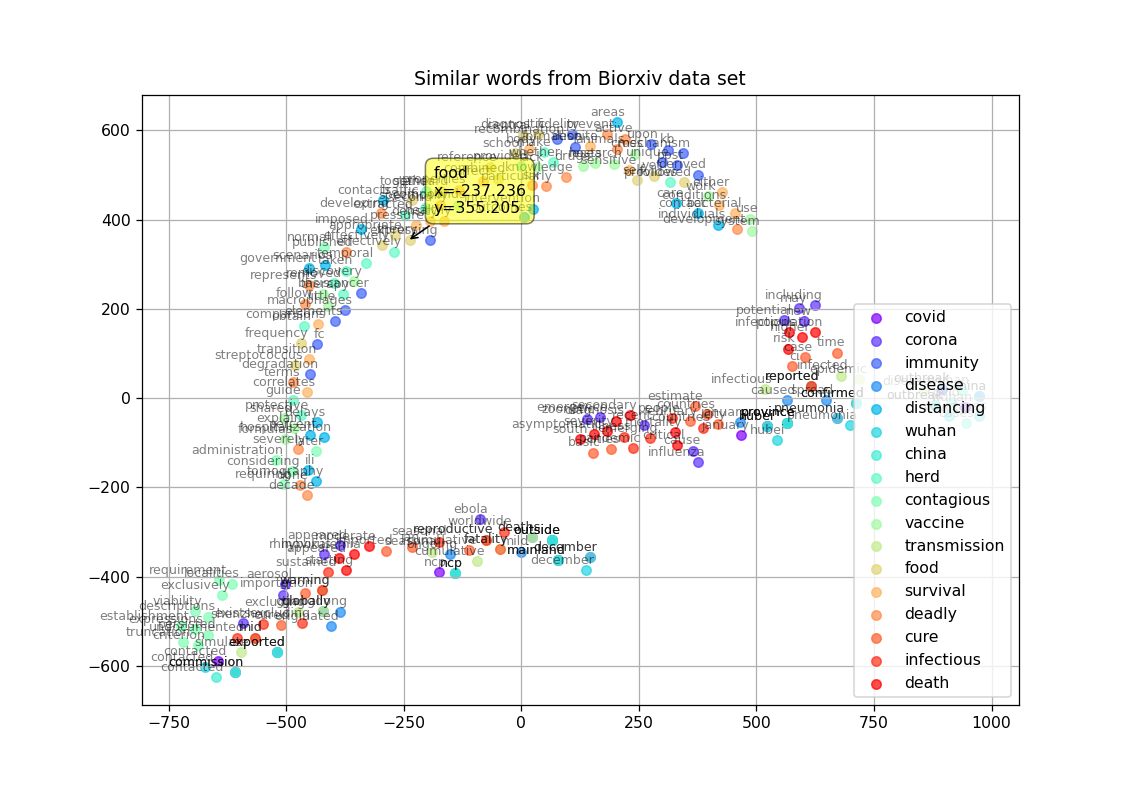

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

In [47]:
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    fig = plt.figure(figsize=(10,7))
    
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)

    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    
    mplcursors.cursor(hover=True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

    
tsne_plot_similar_words('Similar words from Biorxiv data set', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

# Doc2Vec

In [54]:
# collect all abstracts from the data biorxiv data set
biorxiv_abstracts = get_preprocessed_sentences_from_files(biorxiv_json_files, 'abstract')

In [70]:
# create documents
documents = []
analyzedDocument = namedtuple('AnalyzedDocument', 'words tags')
for paper_id in paper_dict:
    text = paper_dict[paper_id]['abstract']
    tags = [paper_id]
    
    sentences = nltk.sent_tokenize(str(text))

    preprocessed_sentences = []
    for sentence in sentences:
        preprocessed_sentences.extend(preprocessing(sentence))

    documents.append(analyzedDocument(preprocessed_sentences, tags))

# train the model
model = doc2vec.Doc2Vec(documents, size=100, window=300, min_count=1, workers=4)

In [68]:
# query the model
query = "What is known about transmission, incubation, and environmental stability".split()

query_vector = model.infer_vector(query)
similar_abstracts = model.docvecs.most_similar([query_vector])

for doc_tags in similar_abstracts:
    abstract = paper_dict[doc_tags[0]]['abstract']
    print(doc_tags[1])
    print(abstract)

0.9076764583587646
['It has become obvious that several interstitial lung diseases, and even viral lung infections, can progress rapidly, and exhibit similar features in their lung morphology. The final histopathological feature, common in these lung disorders, is diffuse alveolar damage (DAD). The histopathology of DAD is considered to represent end stage phenomenon in acutely behaving interstitial pneumonias, such as acute interstitial pneumonia (AIP) and acute exacerbations of idiopathic pulmonary fibrosis (IPF). Acute worsening and DAD may occur also in patients with nonspecific interstitial pneumonias (NSIPs), and even in severe viral lung infections where there is DAD histopathology in the lung. A better understanding of the mechanisms underlying the DAD reaction is needed to clarify the treatment for these serious lung diseases. There is an urgent need for international efforts for studying DAD-associated lung diseases, since the prognosis of these patients has been and is still

['Since the emergence of Middle East respiratory syndrome coronavirus (MERS-CoV) in 2012, there have been a number of clusters of human-to-human transmission. These cases of human-tohuman transmission involve close contact and have occurred primarily in healthcare settings, and they are suspected to result from repeated zoonotic introductions. In this study, we sequenced whole MERS-CoV genomes directly from respiratory samples collected from 23 confirmed MERS cases in the United Arab Emirates (UAE). These samples included cases from three nosocomial and three household clusters. The sequences were analysed for changes and relatedness with regard to the collected epidemiological data and other available MERS-CoV genomic data. Sequence analysis supports the epidemiological data within the clusters, and further, suggests that these clusters emerged independently. To understand how and when these clusters emerged, respiratory samples were taken from dromedary camels, a known host of MERS-C

# BM25 Index

In [76]:
# create documents
documents = []
paper_ids = []
analyzedDocument = namedtuple('AnalyzedDocument', 'words tags')
for paper_id in paper_dict:
    text = paper_dict[paper_id]['abstract']
    tags = [paper_id]
    
    sentences = nltk.sent_tokenize(str(text))

    preprocessed_sentences = []
    for sentence in sentences:
        preprocessed_sentences.extend(preprocessing(sentence))

    documents.append(preprocessed_sentences)
    paper_ids.append(paper_id)

# train the model
bm25_model = BM25Okapi(documents)

In [80]:
def search(search_query, num_results=10):
    preprocessed_search_query = preprocessing(search_query)
    scores = bm25_model.get_scores(preprocessed_search_query)
    top_indexes = np.argsort(scores)[::-1][0:num_results]
    return top_indexes

indexes = search('What is known about transmission, incubation, and environmental stability')
for index in indexes:
    paper_id = paper_ids[index]
    print(paper_dict[paper_id]['abstract'])

['Background: In recent years, much attention has been given to the spread of influenza around the world. With the continuing human outbreak of H5N1 beginning in 2003 and the H1N1 pandemic in 2009, focus on influenza and other respiratory viruses has been increased. It has been accepted for decades that international travel via jet aircraft is a major vector for global spread of influenza, and epidemiological differences between tropical and temperate regions observed. Thus we wanted to study how indoor environmental conditions (enclosed locations) in the tropics and winter temperate zones contribute to the aerosol spread of influenza by travelers. To this end, a survey consisting of 632 readings of temperature (T) versus relative humidity (RH) in 389 different enclosed locations air travelers are likely to visit in 8 tropical nations were compared to 102 such readings in 2 Australian cities, including ground transport, hotels, shops, offices and other publicly accessible locations, al

# Implement a BERT search engine 

Cred to Julien Heiduk (https://www.kaggle.com/zoupet/covid-19-search-engine-with-bert) for the initial idea of using a BERT search engine, which we plan to extend. 

In [0]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

100%|██████████| 405M/405M [00:20<00:00, 19.7MB/s]


In [0]:
question_embedding = model.encode(['What is known about transmission, incubation, and environmental stability?'])

queries = [       "Is the virus transmitted by aerisol, droplets, food, close contact, fecal matter, or water?",
                  "How long is the incubation period for the virus?",
                  "Can the virus be transmitted asymptomatically or during the incubation period?",
                  "How does weather, heat, and humidity affect the tramsmission of 2019-nCoV?",
                  "How long can the 2019-nCoV virus remain viable on common surfaces?"
              ]
query_embeddings = model.encode(queries)

In [0]:
abstract_embeddings = model.encode(df_comm.text.values)

NameError: ignored

In [0]:
# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity

closest_n = 5
for query, query_embedding in zip(queries, query_embeddings):
    distances = sc.spatial.distance.cdist([query_embedding], abstract_embeddings, "cosine")[0]

    results = zip(range(len(distances)), distances)
    results = sorted(results, key=lambda x: x[1])

    print("\n\n======================\n\n")
    print("Query:", query)
    print("\nTop 5 most similar sentences in corpus:")

    for idx, distance in results[0:closest_n]:
        print(df_comm['text'][idx].strip(), "\n(Score: %.4f)" % (1-distance),"\n")





Query: Is the virus transmitted by aerisol, droplets, food, close contact, fecal matter, or water?

Top 5 most similar sentences in corpus:
Porcine Epidemic Diarrhea Virus (PEDV), Porcine Delta Corona Virus (PDCoV), and Transmissible Gastroenteritis Virus (TGEV) are major threats to swine health and contaminated feed plays a role in virus transmission. The objective of our study was to characterize inactivation of PEDV, PDCoV, and TGEV in various feed ingredient matrices. Samples of complete feed, spray dried porcine plasma, meat meal, meat and bone meal, blood meal, corn, soybean meal, and corn dried distillers grains with solubles were weighed (5 g/sample) into scintillation vials and inoculated with 1 mL of PEDV, PDCoV, or TGEV. Samples were incubated at room temperature for up to 56 days. Aliquots were removed at various time points followed by preparing serial 10-fold dilutions and inoculating in cell cultures to determine the amount of surviving virus. Inactivation kinetics w

# Implement a BERT summarizer

In [0]:
from summarizer import Summarizer


In [0]:
body = '''
Those Who Are Resilient Stay In The Game Longer
“On the mountains of truth you can never climb in vain: either you will reach a point higher up today, or you will be training your powers so that you will be able to climb higher tomorrow.” — Friedrich Nietzsche
Challenges and setbacks are not meant to defeat you, but promote you. However, I realise after many years of defeats, it can crush your spirit and it is easier to give up than risk further setbacks and disappointments. Have you experienced this before? To be honest, I don’t have the answers. I can’t tell you what the right course of action is; only you will know. However, it’s important not to be discouraged by failure when pursuing a goal or a dream, since failure itself means different things to different people. To a person with a Fixed Mindset failure is a blow to their self-esteem, yet to a person with a Growth Mindset, it’s an opportunity to improve and find new ways to overcome their obstacles. Same failure, yet different responses. Who is right and who is wrong? Neither. Each person has a different mindset that decides their outcome. Those who are resilient stay in the game longer and draw on their inner means to succeed.
I’ve coached many clients who gave up after many years toiling away at their respective goal or dream. It was at that point their biggest breakthrough came. Perhaps all those years of perseverance finally paid off. It was the 19th Century’s minister Henry Ward Beecher who once said: “One’s best success comes after their greatest disappointments.” No one knows what the future holds, so your only guide is whether you can endure repeated defeats and disappointments and still pursue your dream. Consider the advice from the American academic and psychologist Angela Duckworth who writes in Grit: The Power of Passion and Perseverance: “Many of us, it seems, quit what we start far too early and far too often. Even more than the effort a gritty person puts in on a single day, what matters is that they wake up the next day, and the next, ready to get on that treadmill and keep going.”
I know one thing for certain: don’t settle for less than what you’re capable of, but strive for something bigger. Some of you reading this might identify with this message because it resonates with you on a deeper level. For others, at the end of their tether the message might be nothing more than a trivial pep talk. What I wish to convey irrespective of where you are in your journey is: NEVER settle for less. If you settle for less, you will receive less than you deserve and convince yourself you are justified to receive it.
“Two people on a precipice over Yosemite Valley” by Nathan Shipps on Unsplash
Develop A Powerful Vision Of What You Want
“Your problem is to bridge the gap which exists between where you are now and the goal you intend to reach.” — Earl Nightingale
I recall a passage my father often used growing up in 1990s: “Don’t tell me your problems unless you’ve spent weeks trying to solve them yourself.” That advice has echoed in my mind for decades and became my motivator. Don’t leave it to other people or outside circumstances to motivate you because you will be let down every time. It must come from within you. Gnaw away at your problems until you solve them or find a solution. Problems are not stop signs, they are advising you that more work is required to overcome them. Most times, problems help you gain a skill or develop the resources to succeed later. So embrace your challenges and develop the grit to push past them instead of retreat in resignation. Where are you settling in your life right now? Could you be you playing for bigger stakes than you are? Are you willing to play bigger even if it means repeated failures and setbacks? You should ask yourself these questions to decide whether you’re willing to put yourself on the line or settle for less. And that’s fine if you’re content to receive less, as long as you’re not regretful later.
If you have not achieved the success you deserve and are considering giving up, will you regret it in a few years or decades from now? Only you can answer that, but you should carve out time to discover your motivation for pursuing your goals. It’s a fact, if you don’t know what you want you’ll get what life hands you and it may not be in your best interest, affirms author Larry Weidel: “Winners know that if you don’t figure out what you want, you’ll get whatever life hands you.” The key is to develop a powerful vision of what you want and hold that image in your mind. Nurture it daily and give it life by taking purposeful action towards it.
Vision + desire + dedication + patience + daily action leads to astonishing success. Are you willing to commit to this way of life or jump ship at the first sign of failure? I’m amused when I read questions written by millennials on Quora who ask how they can become rich and famous or the next Elon Musk. Success is a fickle and long game with highs and lows. Similarly, there are no assurances even if you’re an overnight sensation, to sustain it for long, particularly if you don’t have the mental and emotional means to endure it. This means you must rely on the one true constant in your favour: your personal development. The more you grow, the more you gain in terms of financial resources, status, success — simple. If you leave it to outside conditions to dictate your circumstances, you are rolling the dice on your future.
So become intentional on what you want out of life. Commit to it. Nurture your dreams. Focus on your development and if you want to give up, know what’s involved before you take the plunge. Because I assure you, someone out there right now is working harder than you, reading more books, sleeping less and sacrificing all they have to realise their dreams and it may contest with yours. Don’t leave your dreams to chance.
''' 
model = Summarizer()
result = model(body, min_length=60)
full = ''.join(result)
print(full)

Those Who Are Resilient Stay In The Game Longer
“On the mountains of truth you can never climb in vain: either you will reach a point higher up today, or you will be training your powers so that you will be able to climb higher tomorrow.” I can’t tell you what the right course of action is; only you will know. Each person has a different mindset that decides their outcome. Those who are resilient stay in the game longer and draw on their inner means to succeed. No one knows what the future holds, so your only guide is whether you can endure repeated defeats and disappointments and still pursue your dream. “Two people on a precipice over Yosemite Valley” by Nathan Shipps on Unsplash
Develop A Powerful Vision Of What You Want
“Your problem is to bridge the gap which exists between where you are now and the goal you intend to reach.” Gnaw away at your problems until you solve them or find a solution. Nurture it daily and give it life by taking purposeful action towards it. Because I assur

# Search engine

In [74]:
# given a query:string
def search(query):
    query = query.lower()
    return query

In [75]:
print(search("Test BlOO"))

test bloo
